In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from math import log, sqrt, exp
from scipy.stats import norm

Definimos primeiramente um simples portifólio, para implementarmos o delta hedging em python.

Seja $$\pi(t_i, S) = V_c(t_i) - \Delta(t_i)S_i,$$

onde,
 - $t_i$: é o tempo de estudo, onde $0 \leq i \leq t$;
 - $V_c(t_i)$: é o valor da opção no tempo $i$;
 - $\Delta(t_i)$: é a derivada $\frac{\delta V_c(t_i)}{\delta S(t_i)}$;
 - $S_i$: é o valor do ativo no tempo $i$.

#### Definindo o comportamento do ativo

Nesse caso, vamos assumir que o ativo segue um Geometric Brownian Motion (GBM):

$$
S_t = S_0 \exp ( (\mu - \sigma^2/2)t + \sigma W_t),
$$

onde: 
- $\mu$ é o valor esperado de retorno;
- $\sigma$ é a volatilidade do ativo

In [2]:
#np.random.seed(42)

S0 = 100          # initial asset price
K = 100           # strike price
mu = 0.05         # expected return of asset
sigma = 0.20      # volatility
r = 0.03          # risk‑free rate
T_days = 30       # days until option maturity
steps = T_days    # daily steps
dt = 1/365   

In [3]:
S = np.zeros(steps + 1)
S[0] = S0
for t in range(1, steps + 1):
    z = np.random.normal()
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)

### Equação de Black-Scholes

In [4]:
C = np.zeros_like(S)
for t in range(steps + 1):
    tau = (T_days - t) / 365  # time to maturity in years
    if tau > 0:
        d1 = (log(S[t] / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt(tau))
        d2 = d1 - sigma * sqrt(tau)
        C[t] = S[t] * norm.cdf(d1) - K * exp(-r * tau) * norm.cdf(d2)
    else:  # at maturity use payoff
        C[t] = max(S[t] - K, 0)

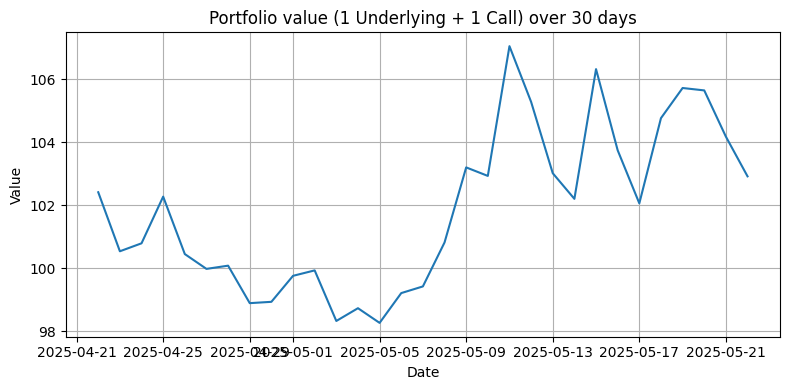

In [5]:

# -----------------------------
# Portfolio value: long 1 underlying + long 1 call
# -----------------------------
V_port = S + C

# -----------------------------
# Build DataFrame
# -----------------------------
start_date = datetime(2025, 4, 22)
dates = [start_date + timedelta(days=i) for i in range(steps + 1)]

df = pd.DataFrame({
    'Date': dates,
    'Underlying': S,
    'CallPrice': C,
    'PortfolioValue': V_port
})


# -----------------------------
# Plot portfolio value
# -----------------------------
plt.figure(figsize=(8, 4))
plt.plot(df['Date'], df['PortfolioValue'])
plt.title('Portfolio value (1 Underlying + 1 Call) over 30 days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

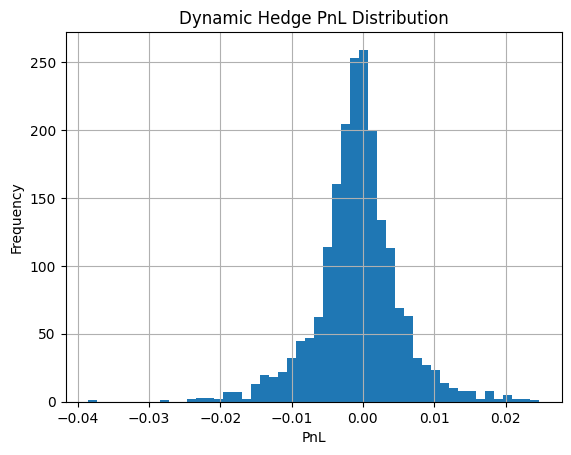

Mean PnL: -0.00075
Std Dev of PnL: 0.00595


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes pricing and delta functions
def bs_price_delta(S, K, r, sigma, T, t):
    tau = T - t
    if tau <= 0:
        # At maturity, price is payoff and delta is indicator(S>K)
        return max(S - K, 0), float(S > K)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

# Simulation parameters
S0 = 1.0      # initial asset price
K = 0.95      # strike
r = 0.1       # risk-free rate
sigma = 0.2   # volatility
T = 1.0       # maturity in years
N = 100       # time steps
dt = T / N
times = np.linspace(0, T, N+1)

# Monte Carlo parameters
M = 2000     # number of simulated paths
pnls = np.zeros(M)

# Run simulations
for m in range(M):
    S_path = np.zeros(N+1)
    S_path[0] = S0
    # Simulate GBM path
    for i in range(N):
        z = np.random.randn()
        S_path[i+1] = S_path[i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    
    # Initialize hedging portfolio
    price, delta = bs_price_delta(S0, K, r, sigma, T, 0)
    # Short one call, so borrow price, buy delta shares
    cash = price - delta * S0
    shares = delta
    
    # Rebalance each step
    for i in range(1, N+1):
        t = times[i]
        S = S_path[i]
        price_new, delta_new = bs_price_delta(S, K, r, sigma, T, t)
        # Accrue cash at risk-free rate
        cash *= np.exp(r * dt)
        # Rebalance shares
        cash -= (delta_new - shares) * S  # pay for change in shares
        shares = delta_new
    
    # Liquidate at maturity
    cash *= np.exp(r * dt)  # final accrual
    # Sell shares
    cash += shares * S_path[-1]
    # Hedging PnL = cash position minus payoff from short call
    payoff = max(S_path[-1] - K, 0)
    pnls[m] = cash - payoff

# Plot PnL distribution
plt.figure()
plt.hist(pnls, bins=50)
plt.title("Dynamic Hedge PnL Distribution")
plt.xlabel("PnL")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print summary statistics
print(f"Mean PnL: {np.mean(pnls):.5f}")
print(f"Std Dev of PnL: {np.std(pnls):.5f}")


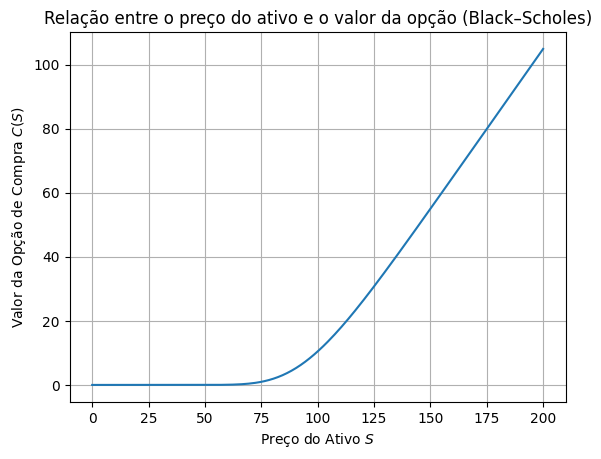

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Função Black-Scholes para opção de compra europeia
def bs_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parâmetros de exemplo
K = 100      # Strike
r = 0.05     # Taxa livre de risco
T = 1.0      # Tempo até vencimento (em anos)
sigma = 0.2  # Volatilidade

# Gera valores de S e calcula o valor da call
S = np.linspace(0.01, 200, 200)
C = bs_call(S, K, r, T, sigma)

# Plota a relação
plt.figure()
plt.plot(S, C)
plt.xlabel('Preço do Ativo $S$')
plt.ylabel('Valor da Opção de Compra $C(S)$')
plt.title('Relação entre o preço do ativo e o valor da opção (Black–Scholes)')
plt.grid(True)
plt.show()


### Profit and Loss ou Lucro e Perda (PnL)

Para explicar o PnL é preciso saber: 
- o que é um portifólio;
- o que é um portifólio dinâmico;
- saber do delta hedging;
- saber o que é o PnL
- ver o PnL no tempo $t_0$;
- ver o PnL no tempo $t_1$;
- ver o PnL no tempo $t_i$;
- ver o PnL no tempo de maturidade (T ou $t_m$);

### Entendendo o $\Delta$

O $\Delta$ é um coeficiente que mostra quanto que o valor do ativo (*stock*) está influenciando no valorização da opção (vamos usar a *call* como exemplo).

$$
\Delta = \frac{\partial V}{\partial S},
$$

onde $\partial V$ é o incremento da call e $\partial S$ o incremento do ativo.

Abaixo uma ilustração desse comportamento:

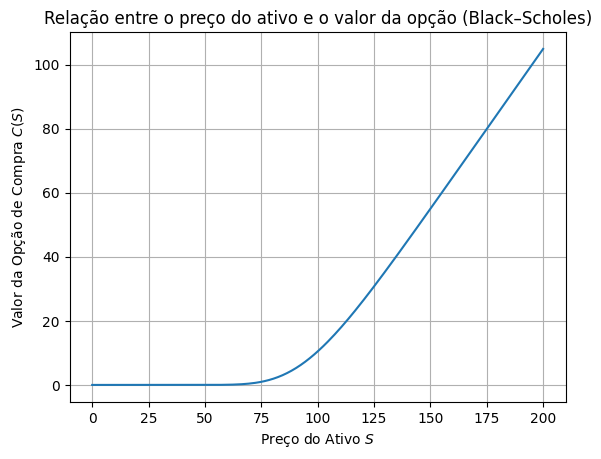

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Função Black-Scholes para opção de compra europeia
def bs_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Parâmetros de exemplo
K = 100      # Strike
r = 0.05     # Taxa livre de risco
T = 1.0      # Tempo até vencimento (em anos)
sigma = 0.2  # Volatilidade

# Gera valores de S e calcula o valor da call
S = np.linspace(0.01, 200, 200)
C = bs_call(S, K, r, T, sigma)

# Plota a relação
plt.figure()
plt.plot(S, C)
plt.xlabel('Preço do Ativo $S$')
plt.ylabel('Valor da Opção de Compra $C(S)$')
plt.title('Relação entre o preço do ativo e o valor da opção (Black–Scholes)')
plt.grid(True)
plt.show()


Note na figura acima quanto que o valor da opção aumenta conforme o preço do ativo cresce. O valor do ativo $S$ nesse cenário seria o valor do ativo $S$, na data de vencimento. No gráfico acima, ao comprar uma opção/*call* com um *strike* de R$ 100,00, note como o gráfico apresenta um comportamento crescente ao longo do eixo y. Essa relação $S$ e $V$ pode ser observada calculando o coeficiente angular gerado por esse crescimento, que nada mais é do que $\frac{\partial V}{\partial S}$. Esse coeficiente mostra o quanto a opção/*call* valoriza a cada incremento em 1 unidade no valor do ativo $S$.

Sabemos que $S$ e $V$ são funções refém do tempo, por isso vai existir um $\Delta$ para cada variação do tempo, ficando da seguinte maneira a notação: $\Delta(t) = \frac{\partial V(t, S)}{\partial S(t)}$

### Portifólio dinâmico

Podemos abordar esse assunto em um cenário simples: temos um portifólio que contém uma opção, nesse caso uma *call* e temos uma certa quantidade de um certo ativo. Nesse caso, temos o seguinte valor do nosso portifólio:

$$
\pi(S) = V_c(S) + \alpha S,
$$

onde:
- $\pi$ é o valor total do portifólio;
- $V_c$ é o valor da *call*;
- $S$ é o valor do ativo;
- $\alpha$ é a quantidade que temos do ativo $S$.

Em um portifólio dinâmico, estamos interessados em saber o comportamento desse portifólio ao longo de tempo, logo:

$$
\pi(S, t) = V_c(S,t) + \alpha S_t,
$$

Note que $0 \leq t \leq T$, logo em $t_0$ temos que o valor do nosso $\pi(t0)$ é igual a certamente o valor que vendemos a *call* $V_c$, nesse caso vamos falar que esse valor é igual a $V_c(t_0, S)$. Vamos supor também que em $t_0$ existia $\alpha$ quantidades do ativo $S$. Temos o seguinte comportamento do ativo $S$ e a valorização da *call* ao longo de $t$.

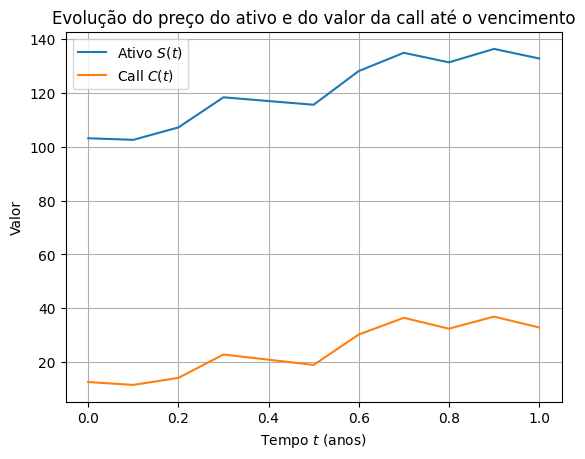

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Parâmetros do modelo
S0 = 100      # Preço inicial do ativo
K = 100       # Strike da opção
r = 0.05      # Taxa livre de risco anual
sigma = 0.2   # Volatilidade anual
T = 1.0       # Tempo até vencimento (anos)

np.random.seed(42)

# Grade de tempo
m = 10 # número de passos (ex: dias úteis)
t = np.linspace(0, T, m + 1)

# Simulação de movimento geométrico browniano
dt = T / m
W = np.cumsum(np.sqrt(dt) * np.random.randn(m + 1))
S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)

# Função de CDF da Normal usando math.erf
vector_erf = np.vectorize(math.erf)
def norm_cdf(x):
    return 0.5 * (1 + vector_erf(x / math.sqrt(2)))

# Função Black-Scholes para call europeia
def bs_call(S, K, r, tau, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm_cdf(d1) - K * np.exp(-r * tau) * norm_cdf(d2)

# Cálculo do valor da call ao longo do tempo
C = []
for i, ti in enumerate(t):
    tau = T - ti
    if tau <= 0:
        C.append(max(S[i] - K, 0))  # payoff no vencimento
    else:
        C.append(bs_call(S[i], K, r, tau, sigma))
C = np.array(C)

# Gráfico único com ativo e call
plt.figure()
plt.plot(t, S, label='Ativo $S(t)$')
plt.plot(t, C, label='Call $C(t)$')
plt.xlabel('Tempo $t$ (anos)')
plt.ylabel('Valor')
plt.title('Evolução do preço do ativo e do valor da call até o vencimento')
plt.legend()
plt.grid(True)
plt.show()


Note no gráfico acima que, ao vender uma *call* em $t_0$ por um valor $V_c(t_0)$ temos esse valor no nosso portifólio. E conforme o ativo cresce ao longo do tempo, maior vai ser o prejuízo que nosso portifólio vai ter, seguido a relação $max\{S(t) - K, 0\}$. 
Pois num cenário de *call*, quando a ação valoriza mais do que o preço de exercício $K$, o *option writter* vai ter um prejuízo de $S - K$.

Para compensar isso, pode-se equilibrar o portifólio ao longo do tempo comprando ou vendendo o mesmo ativo em destaque. Com isso, podemos substituir a equação 

$$
\pi(S, t) = V_c(S,t) + \alpha S_t,
$$

por:

$$
\pi(S, t) = V_c(S,t) - \Delta(t) S_t,
$$

Já que, como vimos anteriormente, a medida $\Delta(t)$ vai nos dar o grau de quanto que ação está impactando no valor da opção. Logo, se meu $\Delta$ é positivo, indicando uma valorização da ação, devemos comprar essa quantidade de ações para balancear o portifólio naquele determinado tempo $t$.

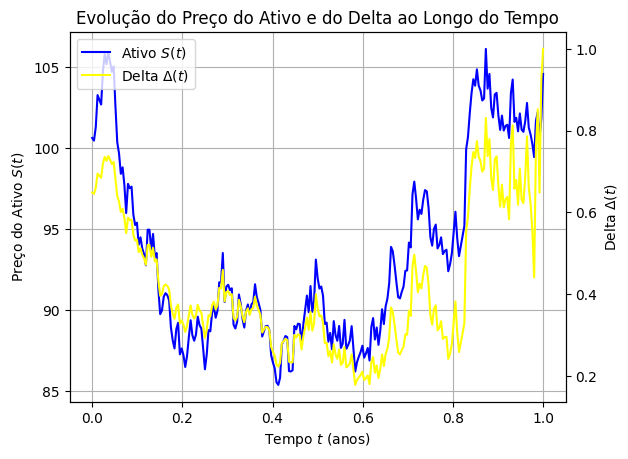

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Parâmetros do modelo
S0 = 100      # Preço inicial do ativo
K = 100       # Strike da opção
r = 0.05      # Taxa livre de risco anual
sigma = 0.2   # Volatilidade anual
T = 1.0       # Tempo até vencimento (anos)
m = 252       # número de passos (dias úteis)

np.random.seed(42)

# Grade de tempo
t = np.linspace(0, T, m + 1)
dt = T / m

# Simulação de movimento geométrico browniano
W = np.cumsum(np.sqrt(dt) * np.random.randn(m + 1))
S = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W)

# CDF da Normal via math.erf
vector_erf = np.vectorize(math.erf)
def norm_cdf(x):
    return 0.5 * (1 + vector_erf(x / math.sqrt(2)))

# Cálculo do delta ao longo do tempo
delta = []
for i, ti in enumerate(t):
    tau = max(T - ti, 1e-9)
    d1 = (np.log(S[i] / K) + (r + 0.5 * sigma**2) * tau) / (sigma * math.sqrt(tau))
    delta.append(norm_cdf(d1))
delta = np.array(delta)

# Plot com eixos duplos
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(t, S, label='Ativo $S(t)$', color="blue")
ax2.plot(t, delta, label='Delta $\\Delta(t)$', color="yellow")

ax1.set_xlabel('Tempo $t$ (anos)')
ax1.set_ylabel('Preço do Ativo $S(t)$')
ax2.set_ylabel('Delta $\\Delta(t)$')
ax1.set_title('Evolução do Preço do Ativo e do Delta ao Longo do Tempo')

# Combine legendas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

ax1.grid(True)

plt.show()
